### DATA CLEANING

1. <b> Remove outliers: </b>
- For each feature for each patient for the total waveform:
    - Calculate the mean
    - Calculate the standard deviation
    - Look at those samples where the value > 10 * standard deviation??: The reason behind this is that normally an outlier is consider as something that is above 3 standard deviations. In this case because we have ill patients we consider bigger standard deviation as plausible values.
    - Subsitute the values where >10 stdandard deviation by NaN
      
2. <b> Looking for features that are not representative: </b>
- Calculate the mean for each patient for the total waveform for each feature
- Create a df where columns are each feature average accross the whole time and rows are each patient
- Look for each feature at the percentage of values that are missing (e.g is 70% it will mean that for 70% of the patients the value of the feature is NaN meaning that there was no data for the whole time for the specific feature)
- Decide on a threshold for a feature to be considered not representative (missing values >70%??)
    - e.g if a feature is missing in more than 70% of the participants we can consider this feature to be non representative and then eliminate the feature
- Eliminate the features that satisfy the threhsold from the analysis

3. <b>Looking for feature stability (to assess whether it makes sense to extract more feature granularity, if a feature is not changing overtime the mean may be representative enough) </b>
- Calculate the mean and the standard deviationfor each patient for the total waveform for each feature
- Extract the coefficient of variation (CV) for each feature and each participant.
The Coefficient is the Normalized Root-Mean-Square Deviation, so we normalize the std deviation to the mean. he higher the coefficient of variation, the greater the level of dispersion around the mean. It is generally expressed as a percentage.
- Decide on a threshold for a CV to be considered variable enough (CV>5%???). For example we may say features that have a CV < 5% we should consider directly the mean, while for the others we can consider to be more granular
- Make a list of the features that satisfy the condition and this feature will be only represented by the mean or the median or whatever.

4. <b> Count the number of samples we have in total for each feature </b>
- For each feature create a column that is the number of total samples
- This will give us an indication of how many values we have per feature, to as well let us know features that have been measured more or less

5. <b> Construct a dataframe given the steps above  </b>
- Each row in the dataframe will be a participant
- Each column in the dataframe will be:
- Features included will be only the ones that were not discarded as being not presentative (e.g < 70% of participants with missing values accross the whole signal)
- Features represented by the total mean if in the analysis above we found that feature is not changing overtime (small coefficient of variation)
- Features represented by hour (eg. HR_hour_1, HR_hour_2.. HR_hour48) if the features have been selected to have enough granularity to be repsented as hourly

In [3]:
import pandas as pd
import pandas as pd
import glob
from pathlib import Path  # Importing the Path class from the pathlib module
import numpy as np
import time
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [4]:
def timeit(func):
    """
    Decorator function to measure the execution time of another function.

    Parameters:
        func (callable): The function to be decorated.

    Returns:
        callable: A wrapper function that measures the execution time of the decorated function.
    """
    def wrapper(*args, **kwargs):
        """
        Wrapper function that measures the execution time of the decorated function.

        Parameters:
            *args: Positional arguments to be passed to the decorated function.
            **kwargs: Keyword arguments to be passed to the decorated function.

        Returns:
            Any: The return value of the decorated function.
        """
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Function '{func.__name__}' elapsed time: {elapsed_time} seconds")
        return result
    return wrapper


### 1. Looking for non representative features and feature stability

In [5]:
@timeit
def process_time_series_files(time_series_files: list, time_parameters: list, non_time_parameters: list, summary_function: callable) -> pd.DataFrame:
    """
    Process a list of time series files and extract summary statistics for each file using a specified summary function.

    Parameters:
        time_series_files (list): A list of file paths to time series data files.
        time_parameters (list): A list of time parameters to calculate metrics for.
        non_time_parameters (list): A list of non-time parameters to extract values for.
        summary_function (callable): A function to calculate summary statistics for a DataFrame.

    Returns:
        pd.DataFrame: A DataFrame containing the summary statistics for all files.
    """
    results = []

    for file_path in time_series_files:
        # Read the file into a DataFrame
        df = pd.read_csv(file_path)
        
        # Extract summary statistics for the DataFrame using the specified summary function
        result = summary_function(df, time_parameters, non_time_parameters)
        
        # Append the result to the results list
        results.append(result)

    # Concatenate results into a single DataFrame
    final_result = pd.concat(results, ignore_index=True)
    
    return final_result


In [6]:
# make a list with all time parameters in the dataset
time_parameters =  ['RecordID', 'Age', 'Gender', 'Height','Albumin', 'ALP', 'ALT ', 'AST', 'Bilirubin', 'BUN', 'Cholesterol', 
                    'Creatinine ', 'DiasABP', 'FiO2 ', 'GCS', 'Glucose', 'HCO3', 'HCT ', 'HR ', 'K',
                    'Lactate', 'Mg', 'MAP ', 'MechVent ', 'Na', 'NIDiasABP', 'NIMAP', 'NISysABP', 'PaCO2', 
                 'PaO2',  'pH', 'Platelets', 'RespRate', 'SaO2', 'SysABP',  'Temp', 'TropI', 'TropT', 'Urine', 'WBC',  'Weight']

non_time_parameters = ['RecordID', 'Age', 'Gender', 'Height']

In [52]:
# store all file paths  in a  list
# Specify the file path using a raw string
files_path = r"C:\Users\egh22\OneDrive - University of Canterbury\bootcamp\group project\data"
# Use glob to find all .txt files in the directory
time_series_files = glob.glob(str(Path(files_path) / "*.txt"))  # Using Path to construct the file path

# Print the number of files found
print(f"Number of text files: {len(time_series_files)}")
#delete this after demonstration


#df = pd.read_csv(time_series_files[1])


Number of text files: 8000


In [53]:
#functions to process files 
def summaryse_features(df: pd.DataFrame, time_features: list, non_time_features: list) -> pd.DataFrame:
    """
    Calculate the mean value, coefficient of variation (CV), and number of samples for each feature,
    after removing outliers.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        features (list): A list of features to calculate the metrics for.
        non_time_features(list): List of features we need to exclude as they have unique value trhough time

    Returns:
        pd.DataFrame: A DataFrame containing the mean value, coefficient of variation (CV), 
                      and number of samples for each feature after removing outliers.
    """
    # Replace '-1' with NaNs
    df = df.replace(-1.0, np.nan)
    
    # Create dictionaries to store the metrics for each feature
    feature_metrics = {}
    
    # Iterate over each feature
    for feat in time_features:
        # if the feature exists for this participant
        if feat in df['Parameter'].unique():  
            # if the feature is age, gender... just take the mean
            if feat in non_time_features:
                feat_df = df[df['Parameter'] == feat]
                feature_metrics[feat] = feat_df['Value'].iloc[0]
            else:
                # Filter the DataFrame for the current feature
                feat_df = df[df['Parameter'] == feat]
                
                # Remove outliers
                std_dev = feat_df['Value'].std()
                outlier_threshold = 10 * std_dev
                feat_df.loc[feat_df['Value'] > outlier_threshold, 'Value'] = np.nan
                
                # Calculate the mean value for the feature
                mean_value = feat_df['Value'].mean()
                
                # Calculate the coefficient of variation for the feature
                std_dev = feat_df['Value'].std()
                coefficient_of_variation = (std_dev / mean_value) * 100 if mean_value != 0 else np.nan
                
                # Get the number of samples for the feature
                num_samples = feat_df['Value'].count()
                
                # Store the metrics for the feature
                feature_metrics[f'{feat}_mean'] = mean_value
                feature_metrics[f'{feat}_CV'] = coefficient_of_variation
                feature_metrics[f'{feat}_num_samples'] = num_samples
        else:
            # if the feature doesn't exist set the feature parameters as NaN
            feature_metrics[f'{feat}_mean'] = np.nan
            feature_metrics[f'{feat}_CV'] = np.nan
            feature_metrics[f'{feat}_num_samples'] = np.nan
        
    # Create a DataFrame with a single row using the feature_metrics dictionary
    result_df = pd.DataFrame([feature_metrics])
    # convert single features back to integers
    result_df['RecordID'] = result_df['RecordID'].astype(float).astype(pd.Int64Dtype(), errors='ignore')
    result_df['Age'] = result_df['Age'].astype(float).astype(pd.Int64Dtype(), errors='ignore')
    result_df['Gender'] = result_df['Gender'].astype(float).astype(pd.Int64Dtype(), errors='ignore')
    
    return result_df

# save dataframe for feature cleaning
result = process_time_series_files(time_series_files, time_parameters, non_time_parameters, summaryse_features)
result.to_csv('result_for_data_cleaning.csv', index=False)

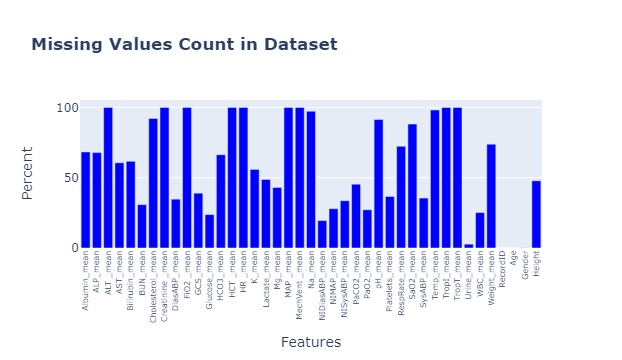

In [96]:

# From results data frame calculate the percentaje of NaNs
# Missing values plot
# Filter the DataFrame to include only features with '_mean' in their names
mean_features = [col for col in result.columns if '_mean' in col]
mean_features.extend(non_time_parameters)
# Calculate the total number of values for each mean feature
total_values = result[mean_features].shape[0]


# Calculate the number of NaN values for each mean feature
missing  = result[mean_features].isna().sum().reset_index()
missing.columns = ['features', 'total_missing']
missing['percent'] = (missing['total_missing'] / total_values) * 100
missing.index = missing['features']
del missing['features']

# Plot the percentage of NaN values
fig = go.Figure(data=[go.Bar(x=missing.index, y=missing['percent'], marker_color='blue')])
fig.update_layout(title='<b>Missing Values Percent in Dataset</b>',
                  xaxis_title='Features',
                  yaxis_title='Percent',
                  xaxis_tickangle=-90,  # Rotate x-axis labels for better visibility
                  )  # Adjust height of the plot as needed
fig.update_layout(xaxis=dict(tickfont=dict(size=8)))
fig.show()

In [101]:
#summaryse CV_Features
CV_features = [col for col in result.columns if '_CV' in col]
# Calculate the total number of values for each mean feature
cv_columns_description = result[CV_features].describe().round(2)
cv_columns_description.to_csv("cv_columns_description.csv")

In [104]:
# summaryse count features
num_samples_features = [col for col in result.columns if '_num_samples' in col]
# Calculate the total number of values for each mean feature
num_samples_columns_description = result[num_samples_features].describe().round(2)
num_samples_columns_description
num_samples_columns_description.to_csv("num_samples_columns_description.csv")

In [ ]:
def extract_to_dict(df: pd.DataFrame, features: list) -> pd.DataFrame:
     """
    Extracts mean values for specified features across different hours from a DataFrame.
    
    Parameters:
    - df (pd.DataFrame): DataFrame containing data.
    - features (list): List of features (parameters) for which mean values need to be extracted.
    
    Returns:
    - pd.DataFrame: DataFrame containing mean values for specified features across different hours.
    
    Note:
    - Replaces all occurrences of -1.0 with NaNs in the DataFrame.
    - Assumes 'Time' column in the DataFrame, converting its values to integer hours.
    - Iterates over each feature, filters the DataFrame for the feature, and calculates the mean value for each hour.
    - Fills missing hours and missing features with NaN values.
    - Constructs a DataFrame with a single row containing mean values for each feature across different hours.
    """
    
    # Replace '-1' with NaNs
    df = df.replace(-1.0, np.nan)
    df['Time'] = df['Time'].apply(lambda x: int(x.split(":")[0]))
    # Create a dictionary to store the columns for each feature
    feature_columns = {}
    
    # Iterate over each feature
    for feat in features:
        # Filter the DataFrame for the current feature
        feat_df = df[df['Parameter'] == feat]
        # Group by hour and calculate mean for each hour
        mean_values = feat_df.groupby('Time')['Value'].mean()
        
        # Fill missing hours with NaN
        for hour in range(49):
            column_name = f"{feat}_hour_{hour}"
            mean_value = mean_values.loc[hour] if hour in mean_values.index else np.nan
            feature_columns[column_name] = mean_value
    
    # Create a DataFrame with a single row using the feature_columns dictionary
    result_df = pd.DataFrame(feature_columns, index=[0])
    
    return result_df


result = extract_to_dict(df, time_parameters)


In [ ]:
def create_df_per_hour(df: pd.DataFrame, features: list) -> pd.DataFrame:
    # Replace '-1' with NaNs
    df = df.replace(-1.0, np.nan)
    
    # Create a DataFrame with all hours from 0 to 48
    all_hours_df = pd.DataFrame({'Time': range(49)})
    
    # Create a dictionary to store the columns for each feature
    feature_columns = {}
    
    for hour in range(49):
        for feat in features:
            column_name = f"{feat}_hour_{hour}"
            if feat in df['Parameter'].unique():
                # Calculate mean value for the parameter at the current hour
                mean_value = df.loc[(df['Parameter'] == feat) & (df['Time'] == hour), 'Value'].mean()
                # Add the mean value to the dictionary
                feature_columns[column_name] = mean_value
            else:
                # If the feature does not exist, set NaN for the current hour
                feature_columns[column_name] = np.nan
    
    # Create a DataFrame with a single row using the feature_columns dictionary
    result_df = pd.DataFrame(feature_columns, index=[0])
    
    return result_df

# Assuming create_df_per_hour function is defined properly

files_path = r"C:\Users\egh22\OneDrive - University of Canterbury\bootcamp\group project\data"
# Use glob to find all .txt files in the directory
time_series_files = glob.glob(str(Path(files_path) / "*.txt"))  # Using Path to construct the file path

# List to store the results for each file
results = []

# Loop through each file
for file_path in time_series_files:
    # Read the file into a DataFrame
    df = pd.read_csv(file_path)
    
    # Create DataFrame per hour using create_df_per_hour function
    result = create_df_per_hour(df, time_parameters)
    
    # Append the result to the results list
    results.append(result)

# Concatenate results into a single DataFrame
final_result = pd.concat(results, ignore_index=True)

# Display the final result
print(final_result)

# Display the final result
print(final_result)




In [ ]:
def create_df_per_hour(df: pd.DataFrame, features: list) -> pd.DataFrame:
    # Replace '-1' with NaNs
    df = df.replace(-1.0, np.nan)
    
    # Create a DataFrame with all hours from 0 to 48
    all_hours_df = pd.DataFrame({'Time': range(49)})
    
    # Create a dictionary to store the columns for each feature
    feature_columns = {}
    
    # Set single values for 'RecordID', 'Age', 'Height', and 'Gender'
    for feat in ['RecordID', 'Age', 'Height', 'Gender']:
        if feat in df['Parameter'].unique():
            value = df.loc[df['Parameter'] == feat, 'Value'].iloc[0]
            feature_columns[feat] = value
    
    # Calculate mean values for other features over the hours
    for feat in features:
        if feat not in ['RecordID', 'Age', 'Height', 'Gender']:
            mean_values = []
            for hour in range(49):
                # Get values for the current hour
                values_hour = df.loc[(df['Parameter'] == feat) & (df['Time'] == hour), 'Value']
                if not values_hour.empty:
                    mean_value = values_hour.mean()
                else:
                    mean_value = np.nan
                mean_values.append(mean_value)
            if not all(np.isnan(mean_values)):
                feature_columns[feat] = np.nanmean(mean_values)  # Using np.nanmean to handle NaN values
            else:
                feature_columns[feat] = np.nan
    
    # Create a DataFrame with a single row using the feature_columns dictionary
    result_df = pd.DataFrame(feature_columns, index=[0])
    
    return result_df

create_df_per_hour(df, time_parameters)